In [1]:
import os
import gsw
import json
import glob
import netCDF4
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from oxygen_calculation import calc_o2, oxygen_solubility, SVU

In [24]:
# Configuration information
glider = '559'
glider_type = 'GL'
array = 'CP05MOAS'
deployment = 2
data_type = 'recovered'
decimation_factor = .10
depth_limiter = 2.5
o2_config = "0436_20200211_SVU"

In [3]:
# Set local static paths
project_path = '/Users/cdobson/Documents/Datateam/optode/'
data_path = '/Volumes/data/'

local_input = os.path.join(project_path, 'input/')
local_output = os.path.join(project_path, 'output/')
cache_dir = os.path.join(project_path, 'cache/')
config_dir = os.path.join(project_path, 'config/')

os.chdir(project_path)

In [25]:
deployment = '{:05d}'.format(deployment)
o2_config_file = config_dir+'config_{:s}.json'.format(
    o2_config)
print(o2_config_file)

/Users/cdobson/Documents/Datateam/optode/config/config_0436_20200211_SVU.json


In [5]:
# Select the file type based on data type
if data_type == 'telemetered':
    file_type = 'tbd'
    dir_type = 'D'
    dir_name = 'from-glider'
else: 
    file_type = 'EBD'
    dir_type = 'R'
    dir_name = 'science'

# Build dynamic local paths based on local static paths
save_dir = local_output+array+"-"+glider_type+glider+"/"+dir_type+(deployment.zfill(5))+"/"
full_path = data_path+array+"-"+glider_type+glider+"/"+dir_type+(deployment.zfill(5))+"/"+dir_name
all_files = glob.glob(full_path + "/*."+file_type)
input_path = local_input+array+"-"+glider_type+glider+"/"+dir_type+(deployment.zfill(5))+"/"

In [6]:
# Make the input directory if it does not exist
CHECK_FOLDER = os.path.isdir(input_path)
if not CHECK_FOLDER:
    os.makedirs(input_path)
    
# Grab a subset of total EBD files at random determined by decimation_factor
random_files = np.random.choice(all_files, int(len(all_files)*decimation_factor))

# Rsync the randomly selected files to the processing area 
for file in random_files:
    bashCommand = "rsync -aP "+file+" "+input_path+""
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

In [7]:
# Set more dynamic paths for processing data
input_dir = os.path.join(local_input, array+"-"+glider_type+glider, dir_type+(deployment.zfill(5)), "*."+file_type)
output_dir = os.path.join(local_output, array+"-"+glider_type+glider, dir_type+(deployment.zfill(5)))
output_name = os.path.join(output_dir, glider_type+glider+"_"+dir_type+(deployment.zfill(5))+".nc")

# Make the output directory if it does not exist
CHECK_FOLDER = os.path.isdir(output_dir)
if not CHECK_FOLDER:
    os.makedirs(output_dir)

In [8]:
# Execute the dbd2netCDF program to create a single netcdf file
dbd2netCDF_command = "dbd2netCDF -C "+cache_dir+" -o "+output_name+" "+input_dir+""
process = subprocess.Popen(dbd2netCDF_command, stdout=subprocess.PIPE, shell=True)
output, error = process.communicate()

In [26]:
# Load in the netCDF file
nc = netCDF4.Dataset(
    output_name)

In [27]:
# retrieve oxygen data from the netCDF file
oxygen = nc['sci_oxy4_oxygen'][:].data
scitime = nc['sci_m_present_time'][:].data
pressure = nc['sci_water_pressure'][:].data*10
saturation = nc['sci_oxy4_saturation'][:].data

if glider_type == 'GL' and data_type == 'telemetered':
    oxytemp = nc['sci_water_temp'][:].data
else: 
    oxytemp = nc['sci_oxy4_temp'][:].data


nc.close()

In [28]:
# Load the data into a dataframe 
df = pd.DataFrame(columns=['sci_time','pressure', 'oxygen'])
df['oxy_temp'] = oxytemp
df['sci_time'] = scitime
df['pressure'] = pressure*10
df['interp_pressure'] = df['pressure']
df['oxygen'] = oxygen
df['saturation'] = saturation
df['oxytemp'] = oxytemp
df = df[df['oxygen'] > 0]
df['oxy_mean'] = df['oxygen'].mean()
df['time'] = pd.to_datetime(df['sci_time'],unit='s')

# filter the dataframe to remove all non-surface measurements
df_filtered = df[df['oxygen'] > 0]
df_filtered = df_filtered[df_filtered['pressure'] < depth_limiter]
df_filtered['oxy_mean'] =  df_filtered['oxygen'].mean()

In [29]:
# Calculate solubility
df['o2_solubility'] = df['oxygen'] / (df['saturation'] / 100)
from_gsw_0 = gsw.O2sol_SP_pt(0, df['oxytemp'])
from_gsw_35 = gsw.O2sol_SP_pt(35, df['oxytemp'])

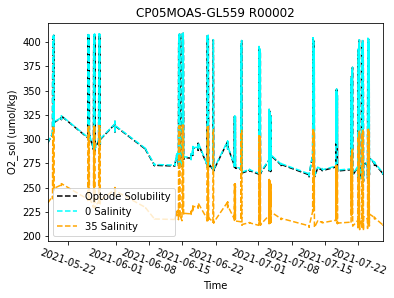

In [30]:
# Plot solubility 
plt.plot(df['time'], df['o2_solubility'], '--', color='black', label='Optode Solubility')
plt.plot(df['time'], from_gsw_0, '--', color='cyan', label='0 Salinity')
plt.plot(df['time'], from_gsw_35, '--', color='orange', label='35 Salinity')

# Set y limits 
#plt.ylim([200, 425])

# Set x limits based on time
min_time = df['time'].min()
max_time = df['time'].max()
plt.xlim([min_time, max_time])
plt.xticks(rotation = -20)

# Labels
plt.xlabel('Time')
plt.ylabel('O2_sol (umol/kg)')
title = array+"-"+glider_type+glider+" "+dir_type+deployment
plt.title(title)
plt.legend()

# Save the figure 
save = output_dir+'/'+array+"-"+glider_type+glider+"_"+dir_type+(deployment.zfill(5))+"_solubility.png"
plt.savefig(save)

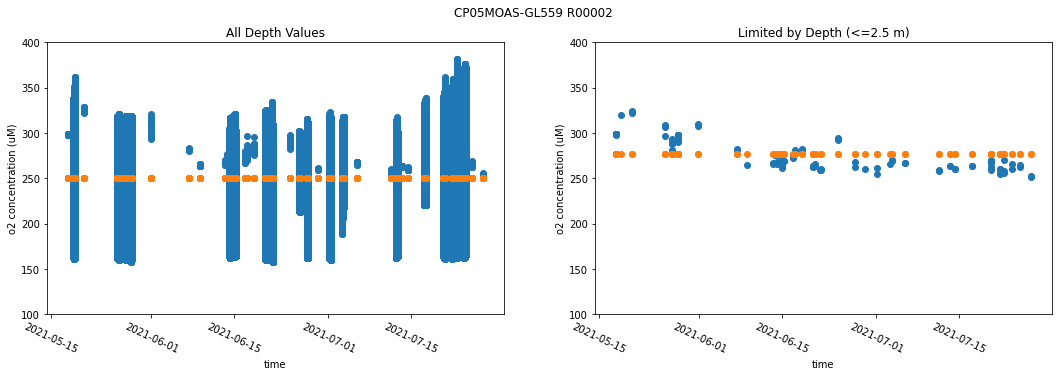

In [31]:
# Create subplot for oxygen readings at all depth values
fig=plt.figure(figsize=(18, 5))
plt.subplot(121)
plt.scatter(df['time'],df['oxygen']);
plt.scatter(df['time'],df['oxy_mean']);
plt.ylabel('o2 concentration (uM)')
plt.xlabel('time')
plt.ylim([100, 400])
plt.xticks(rotation = -25)
plt.title('All Depth Values')
title = array+"-"+glider_type+glider+" "+dir_type+deployment
fig.suptitle(title)

# Create subplot for oxygen readings at depth values less than modifier 
plt.subplot(122)
plt.scatter(df_filtered['time'],df_filtered['oxygen']);
plt.scatter(df_filtered['time'],df_filtered['oxy_mean']);
plt.ylabel('o2 concentration (uM)')
plt.xlabel('time')
plt.ylim([100, 400])
plt.xticks(rotation = -25)
plt.title('Limited by Depth (<='+str(depth_limiter)+' m)')
title = array+"-"+glider_type+glider+" "+dir_type+deployment
fig.suptitle(title)

# Save the figure 
save = output_dir+'/'+array+"-"+glider_type+glider+"_"+dir_type+(deployment.zfill(5))+"_eyeball_method.png"
plt.savefig(save)

In [32]:
#########################
# Stuart's method below #
#########################

In [33]:
# Oxygen processing
nc = netCDF4.Dataset(
    # networked directory 
    # 'Z:/data/' + glider + '/' + deployment + '/nc/' 
    # + glider + '_' + deployment + '.ebd.nc')
    # local directory
    output_name)

In [34]:
# retrieve oxygen data
oxy = nc['sci_oxy4_oxygen'][:].data
calphase = nc['sci_oxy4_calphase'][:].data
oxytemp = nc['sci_oxy4_temp'][:].data
scitime = nc['sci_m_present_time'][:].data
nc.close()

# process out zeros where instrument initializes
zeros = np.flatnonzero(calphase == 0.0)
calphase[zeros] = np.nan
oxy[zeros] = np.nan
oxytemp[zeros] = np.nan

# get only the finite values (i.e. remove NaNs)
finites = np.flatnonzero(np.isfinite(calphase))
oxy = oxy[finites]
oxytemp = oxytemp[finites]
calphase = calphase[finites]
oxytime = scitime[finites]
# convert unix timestamps to pandas datetime array
oxyts = pd.to_datetime(oxytime * 1e9)

In [38]:
# Make sure to use the correct config json or create one if it does not exist.
with open(o2_config_file, 'r') as fid:
    foil_cals = json.load(fid)
calctype = foil_cals["calculation_type"]
print("Calc Type = {:s}".format(calctype))
if calctype == "MkII":
    C = foil_cals["C"]
    M = foil_cals["FoilPolyDegT"]
    N = foil_cals["FoilPolyDegO"]
elif calctype == "SVU":
    csv = foil_cals["SVUFoilCoef"]
    print("SVU = [")
    for val in csv:
        print("  {:f}".format(val))
    print("  ]")
cc = foil_cals["ConcCoef"]
fwv = foil_cals['firmware_version']
print("Firmware version = {:s}".format(fwv))
print("ConcCoef = [{:f} {:f}]".format(cc[0], cc[1]))

Calc Type = SVU
SVU = [
  0.002687
  0.000117
  0.000002
  229.263000
  -0.360716
  -56.083900
  4.571270
  ]
Firmware version = 
ConcCoef = [-5.202351 1.018283]


In [39]:
if calctype == "MkII":
    if fwv == "1.25.2":
        igc=True
    else:
        igc=False
    
    oxy_calc_0 = calc_o2(calphase, oxytemp, C, M, N, cc=cc, S=0, idealgc=igc)[0]
    oxy_calc_35 = calc_o2(calphase, oxytemp, C, M, N, cc=cc, S=35, idealgc=igc)[0]
elif calctype == "SVU":
    oxy_calc_0 = SVU(calphase, oxytemp, csv, conc_coef=cc, SP=0)
    oxy_calc_35 = SVU(calphase, oxytemp, csv, conc_coef=cc, SP=35)

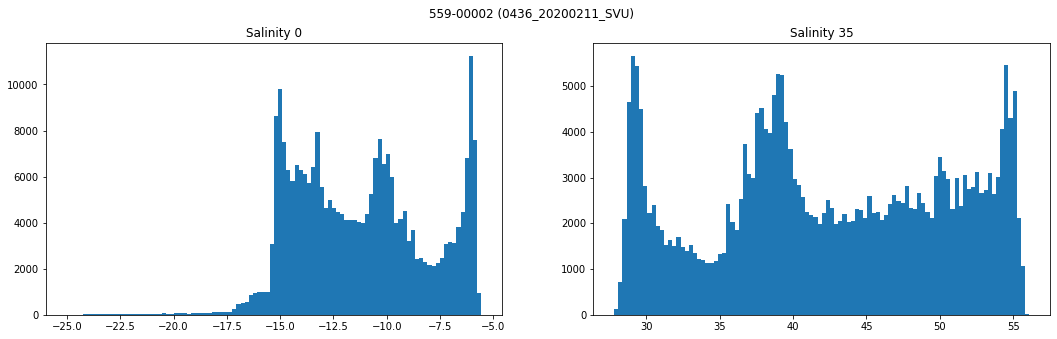

In [40]:
fig=plt.figure(figsize=(18, 5))
plt.subplot(121)
plt.hist(oxy - oxy_calc_0, 100);
plt.title('Salinity 0')
plt.subplot(122)
plt.hist(oxy - oxy_calc_35, 100);
plt.title('Salinity 35')
fig.suptitle('{:s}-{:s} ({:s})'.format(glider, deployment, o2_config));
 
#save = output_dir+'/'+array+"-"+glider_type+glider+"_R"+(deployment.zfill(5))+"_"+o2_config+".png"
#plt.savefig(save)

In [23]:
# AUV PROCESSING BELOW # 

In [89]:
# Load in the netCDF
input_name = '/Users/cdobson/Downloads/deployment0012_CP05MOAS-A6263-02-DOSTAN000-recovered_host-dosta_ln_auv_instrument_recovered_20210413T232800.583000-20210414T214031.199000.nc'
nc = netCDF4.Dataset(
    input_name)

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/cdobson/Downloads/deployment0012_CP05MOAS-A6263-02-DOSTAN000-recovered_host-dosta_ln_auv_instrument_recovered_20210413T232800.583000-20210414T214031.199000.nc'

In [71]:
# Load in the data
auv_mission_time = nc['mission_time'][:].data
auv_optode_temperature = nc['optode_temperature'][:].data
auv_oxy_concentration = nc['estimated_oxygen_concentration'][:].data
#auv_oxy_saturation = nc['calculated_oxygen_saturation'][:].data
auv_oxy_saturation = nc['estimated_oxygen_saturation'][:].data
auv_depth = nc['m_depth'][:].data

In [72]:
deployment_day = '2021-04-13'
deployment_day_ms = 1618272000000

In [73]:
# Load the data into a dataframe 
df = pd.DataFrame(columns=['mission_time','depth', 'optode_temp', 'oxy_concentration', 'oxy_saturation', 'depth'])
df['mission_time'] = auv_mission_time+deployment_day_ms
df['mission_time'] = pd.to_datetime(df['mission_time'],unit='ms')
df['optode_temp'] = auv_optode_temperature
df['oxy_concentration'] = auv_oxy_concentration
df['oxy_saturation'] = auv_oxy_saturation
df['depth'] = auv_depth

In [75]:
# Calculate solubility
df['o2_solubility'] = df['oxy_concentration'] / (df['oxy_saturation'] / 100)
from_gsw_0 = gsw.O2sol_SP_pt(0, df['optode_temp'])
from_gsw_35 = gsw.O2sol_SP_pt(35, df['optode_temp'])

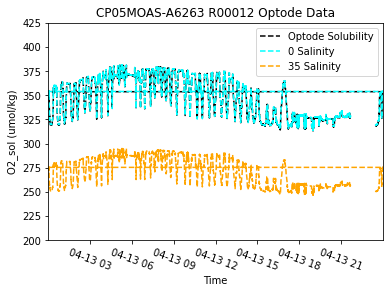

In [76]:
# Plot solubility 
plt.plot(df['mission_time'], df['o2_solubility'], '--', color='black', label='Optode Solubility')
plt.plot(df['mission_time'], from_gsw_0, '--', color='cyan', label='0 Salinity')
plt.plot(df['mission_time'], from_gsw_35, '--', color='orange', label='35 Salinity')


# Set y limits 
plt.ylim([200, 425])

# Set x limits based on time
min_time = df['mission_time'].min()
max_time = df['mission_time'].max()
plt.xlim([min_time, max_time])
plt.xticks(rotation = -20)

# Labels
plt.xlabel('Time')
plt.ylabel('O2_sol (umol/kg)')
title = "CP05MOAS-A6263 R00012 Optode Data"
plt.title(title)
plt.legend()

# Save the figure 
#save = output_dir+'/'+array+"-"+glider_type+glider+"_"+dir_type+(deployment.zfill(5))+"_solubility.png"
#plt.savefig(save)